# Graph embedding using GloVe
[GloVe embeddings are global embeddings](https://www.aclweb.org/anthology/D14-1162.pdf_). A GloVe model tries to predict, given two elements out of the corpus vocabulary, their cooccurrence frequency.

GloVe model do not scale nicely with the graph size, as the cooccurrence matrix requires to be fully rendered (clearly as a CSR) before the model is trained, hence occupying a significant memory portion on huge graphs.

In [1]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

## Loading the graphs
We load the ppi graph from the repository as a weighted undirected graph.

To load the graph we are using the sister package of Embiggen called [Ensmallen](https://github.com/LucaCappelletti94/ensmallen_graph). Ensmallen is a Rust library with python bindings to handle processing of graph files and preprocessing of data for quickly training embedding models.

It also supports numerous utilities that can be helpful when dealing with graphs, such as ways to compute holdouts of different kinds on the graph edges.

In [2]:
from ensmallen_graph import EnsmallenGraph

graph = EnsmallenGraph.from_csv(
    edge_path="../data/ppi/edges.tsv",
    sources_column="subject",
    destinations_column="object",
    directed=False,
    weights_column="weight"
)

As first thing, we print a short report showing all the avalable graph details, including the number of edges, nodes, trap nodes and both the connected components and the strongly connected components.

In [3]:
graph.report()

{'nodes_number': '17185',
 'bidirectional_percentage': '1',
 'unique_edge_types_number': '0',
 'traps_rate': '0',
 'singleton_nodes': '0',
 'edges_number': '588748',
 'degrees_mode': '1',
 'connected_components_number': '181',
 'selfloops_percentage': '0',
 'density': '0.001993564869255138',
 'is_directed': 'false',
 'unique_node_types_number': '0',
 'degrees_mean': '34.25941227814955',
 'strongly_connected_components_number': '181',
 'degrees_median': '11'}

## Creating the training and validation partitions
To execute the embedding of the graph with the goal of running Link Prediction on the obtained vectors (after having obtained the edges embeddings from the nodes embeddings), we need to create two partitions of the graph. One containing the training set edges, which is left connected (if the initial graph was connected) or at least with the same number of connected components are the initial graph, and one containing the validation set edges, which may not be connected.

The requirement for connectivity is stated in the seminal work from [Leskovec et al.](https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf) but we have no proofs, currently, that actually changes performance of the embedding.

#### Limitation in using connected training set
Creating holdouts in this fashion allows us to estimate the real-world model performance only for cases when the new edges that we intend to predict are part of the existing graph components and do not ever connect separated components of the graph.

### Why not simply using the complete graph in the embedding process
If we were to use the complete graph during the embedding process, we would end up encoding the answers for the Link Prediction problem into the embedding for both the training and validation partitions, hence adding a positive bias that would inflate the performance of the models.

**NB: the entire graph should be used for embeddings when the task will be a node-label prediction task, when no nodes labels are taken in consideration in any shape of form during the random walks.**

### The inevitable presence of false negatives in the embedding training process

In the training set of the model there will be inevitably some false negatives. These originates from the sampling of random edges as negatives.

In Binary SkipGram, meaning the models that receive two words and tries to predict if the connection exists or not, this sampling is needed to produce negative examples so that the network don't overfit returning always true.

In Categorical-Models, such as CBOW and non-binary SkipGram, meaning the one which either receive the context and tries to predict the central word, or receives the word and tries to predict the context, the sample is only present if they use the [Noise Contrastive Estimation (NCE)](https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss) loss which, instead of computing the softmax and the categorical cross entropy, samples a random number of categories per batch and applies, to the choosen outputs, a sigmoid activation function, hence computing the logits, and then computes the binary cross-entropy for each of them. Finally the losses are summed to obtain the final loss.

In this case, the problem of false negatives araise from the fact that during the computation of the NCE loss, in order to have negative examples, the function samples random words to use as wrong predictions for the given context. This of course could create false negatives if the choosen random word appears in another batch with the same context, and can be easily shown that this leads to sampling potentialy false negative edges.

The only method to avoid these is to do the **embedding on the whole graph** which create a positive bias for the link-prediction.
This bias is formed because the embedding is encoding the data by learning which nodes are close and **thus is encoding the link prediction of the validation set and invalidating the link-prediction performances**.

Therefore, the only way is to accept the false negatives since in a real world application the link prediction is used as an oracle to explore new possible edges. 

#### Additional false positives relative to collisions with known training edges
For the same sampling issue, there will be also collisions with the training edges. This should be a lesser problem though, as the model will be more likely to see the positive label for any given training edge that the collision, though to the strong imbalance between the number of available training edges and the complete number of edges.

This imbalance, in PPI, is around 1 positive edge to 1000 negative edges.

### Early stopping criterion for the embedding process
For the early stopping criterion used in the embedding process, during the model selection (the procedure where we select the optimal $p$, $q$ and embedding size parameters, amongs others) we can use the validation partition to stop the training early (hence early stopping) when a metric representing of the quality of the embedding stops improving.

Since the validation set is not connected we cannot diretly use the validation set for th early stopping, as it would not allow us to create random walks that represent the graph structure.

For this reason we need to use the entire training+validation set for the early stopping. This will allow us to compute random walks that should be representative of the graph structure.

The validation edges are never fed into the training model as positives, but are only used in the context of the early stopping.

### Splitting the graph into the two edge partitions
As described above, we split the graphs into two partitions:

- The training component, with the same number of components as the initial graph
- The validation component, that may have more components than the initial graph

In [4]:
training, validation = graph.connected_holdout(42, 0.8)

The followings are check that are not necessary, but are offered as sanity checks:

In [5]:
assert graph > training
assert graph > validation
assert (training + validation).contains(graph)
assert graph.contains(training + validation)
assert not training.overlaps(validation)
assert not validation.overlaps(training)

### Considered parameters
We are going to use the following parameters:

- **Walk lengths:** $100$ nodes.
- **Batch size:** $2^{7} = 128$ walks per batch.
- **Walk iterations:** $20$ iterations on the graph.
- **Window size:** $4$ nodes, meaning $4$ on the left and $4$ on the right of the center nodes. Consider that the first *window_size* values on the left and the right of the walks will be trimmed.
- **Return weight, inverse of $p$:** $1.0$.
- **Explore weight, inverse of $q$:** $1.0$.
- **Embedding size:** $100$.
- **Optimizer:** [Nadam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam).
- **Early stopping parameters:** We are going to use an Early Stopping criterion on the *validation loss*, with patience $5$ and delta $0.0001$.
- **Epochs:** The model will be trained up to $1000$ epochs.
- **Learning rate:** since tipically the loss function is quite convex for the embedding problem, we can use a relatively higher learning rate. We are going to us $0.1$ for this example, to get to a faster convergence: this might lead to skipping some better minima that might be identified with a lower learning rate, such as the default one which is $0.0001$.
- **Glove loss alpha:** 0.75

#### Setting up the parameters

In [18]:
walk_length=100
batch_size=2**20
iterations=20
window_size=4
p=1.0
q=1.0
embedding_size=100
patience=5
delta=0.0001
epochs=1000
learning_rate=0.1
glove_alpha=0.75

#### Creating the training and validation Keras sequences

In [7]:
train_words, train_contexts, train_labels = training.cooccurence_matrix(
    walk_length,
    window_size=window_size,
    iterations=iterations,
    return_weight=1/p,
    explore_weight=1/q
)

valid_words, valid_contexts, valid_labels = graph.cooccurence_matrix(
    walk_length,
    window_size=window_size,
    iterations=iterations,
    return_weight=1/p,
    explore_weight=1/q
)

## Creating the GloVe model
We are going to setup the model to use, if available, multiple GPUs.

In [10]:
from tensorflow.distribute import MirroredStrategy
from embiggen import GloVe

strategy = MirroredStrategy()
with strategy.scope():
    model = GloVe(
        vocabulary_size=training.get_nodes_number(),
        embedding_size=embedding_size,
        alpha=glove_alpha
    )

model.summary()

Model: "GloVe"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_embedding (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1718500     words_embedding[0][0]            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1718500     input_1[0][0]                    
______________________________________________________________________________________________

## Tuning the GloVe model

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    (train_words, train_contexts), train_labels,
    validation_data=((valid_words, valid_contexts), valid_labels),
    epochs=1000,
    batch_size=batch_size,
    callbacks=[
        EarlyStopping(
            "val_loss",
            min_delta=delta,
            patience=patience,
            restore_best_weights=True
        )
    ]
)

Epoch 1/1000
26/26 [==============================] - 11s 418ms/step - loss: 0.0349 - val_loss: 0.0373
Epoch 2/1000
26/26 [==============================] - 9s 356ms/step - loss: 0.0331 - val_loss: 0.0353
Epoch 3/1000
26/26 [==============================] - 9s 363ms/step - loss: 0.0312 - val_loss: 0.0332
Epoch 4/1000
26/26 [==============================] - 9s 360ms/step - loss: 0.0293 - val_loss: 0.0311
Epoch 5/1000
26/26 [==============================] - 9s 358ms/step - loss: 0.0274 - val_loss: 0.0290
Epoch 6/1000
26/26 [==============================] - 10s 368ms/step - loss: 0.0256 - val_loss: 0.0270
Epoch 7/1000
26/26 [==============================] - 9s 364ms/step - loss: 0.0238 - val_loss: 0.0250
Epoch 8/1000
26/26 [==============================] - 9s 358ms/step - loss: 0.0221 - val_loss: 0.0233
Epoch 9/1000
26/26 [==============================] - 9s 356ms/step - loss: 0.0205 - val_loss: 0.0216
Epoch 10/1000
26/26 [==============================] - 9s 356ms/step - loss: 0.0

26/26 [==============================] - 9s 359ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 81/1000
26/26 [==============================] - 9s 356ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 82/1000
26/26 [==============================] - 9s 356ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 83/1000
26/26 [==============================] - 9s 365ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 84/1000
26/26 [==============================] - 9s 355ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 85/1000
26/26 [==============================] - 9s 362ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 86/1000
26/26 [==============================] - 9s 358ms/step - loss: 0.0036 - val_loss: 0.0040


### Saving the model weights
We save the obtained model weights:

In [20]:
model.save_weights(f"{model.name}_weights.h5")

### Visualizing the training history
We can visualize the performance of the model during the training process as follows:

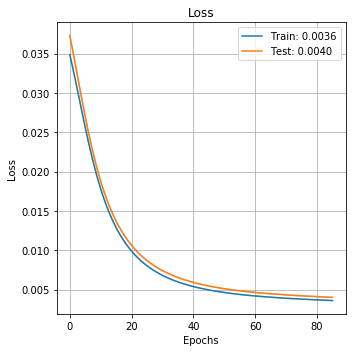

In [21]:
from plot_keras_history import plot_history

plot_history(history)

There may be some hickups in the plot of the history if the model is reloaded from stored weights: [this is a known Keras issue](https://github.com/keras-team/keras/issues/4875) and is not related to either the holdouts used or the model.

## Saving the obtained embeddings
Finally we save our hard earned model embeddings. In another notebook we will show how to do link prediction on the obtained embedding.

In [22]:
import numpy as np

np.save(f"{model.name}_embedding.npy", model.embedding)